<a href="https://colab.research.google.com/github/algomaschine/AlgoMaschine/blob/master/Seasonalities_(Ramina_Version).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# вот этот код надо запустить ОДИН раз при открытии документа https://colab.research.google.com/drive/1o5okODwfd__yxhNWY9o32ndvvxxrcrib?usp=sharing
!pip install pandas_bokeh
!pip install yfinance
import requests
from statsmodels.tsa.stattools import adfuller
from fbprophet.plot import plot_plotly, plot_components_plotly, plot_weekly, seasonality_plot_df
from fbprophet.plot import add_changepoints_to_plot
import pandas_bokeh
import datetime
!pip install yfinance 
!pip install yahoofinancials
!pip install pygal
!pip install pandas_bokeh
import yfinance as yf
from yahoofinancials import YahooFinancials
import pygal
import numpy as np
import pandas as pd
import time
import fnmatch
from time import gmtime, strftime
from pygal.style import Style
from datetime import datetime, timedelta, date
from calendar import monthrange
from multiprocessing import Pool
from matplotlib.pylab import plt #load plot library
import itertools
import shutil
import sys
from fbprophet import Prophet
import os, fnmatch

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                Close         ds
2019-09-18  64.559189 2019-09-18
2019-09-19  64.203316 2019-09-19
2019-09-20  64.074692 2019-09-20
2019-09-21  64.164474 2019-09-21
2019-09-22  64.156067 2019-09-22
                 time      value
2019-09-18 2019-09-18  64.559189
2019-09-19 2019-09-19  64.203316
2019-09-20 2019-09-20  64.074692
2019-09-21 2019-09-21  64.164474
2019-09-22 2019-09-22  64.156067


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                Close         ds
2011-11-21  75.989998 2011-11-21
2011-11-22  76.400002 2011-11-22
2011-11-23  76.800003 2011-11-23
2011-11-24  73.820000 2011-11-24
2011-11-25  78.269997 2011-11-25
                 time      value
2011-11-21 2011-11-21  75.989998
2011-11-22 2011-11-22  76.400002
2011-11-23 2011-11-23  76.800003
2011-11-24 2011-11-24  73.820000
2011-11-25 2011-11-25  78.269997


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



                Close         ds
2010-01-04  30.950001 2010-01-04
2010-01-05  30.959999 2010-01-05
2010-01-06  30.770000 2010-01-06
2010-01-07  30.450001 2010-01-07
2010-01-08  30.660000 2010-01-08
                 time      value
2010-01-04 2010-01-04  30.950001
2010-01-05 2010-01-05  30.959999
2010-01-06 2010-01-06  30.770000
2010-01-07 2010-01-07  30.450001
2010-01-08 2010-01-08  30.660000


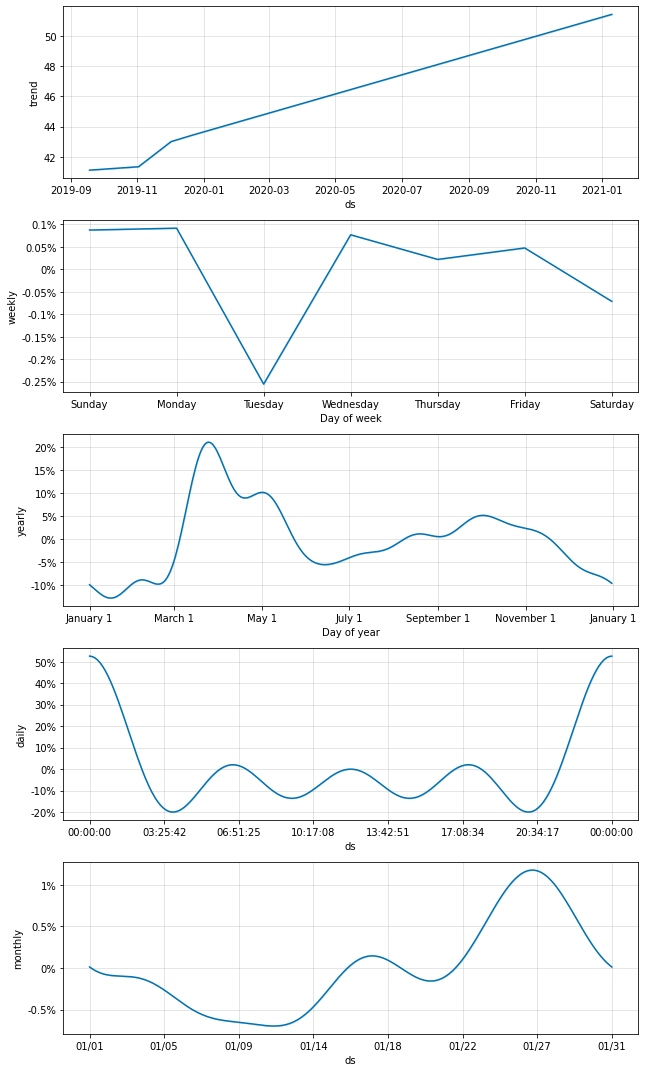

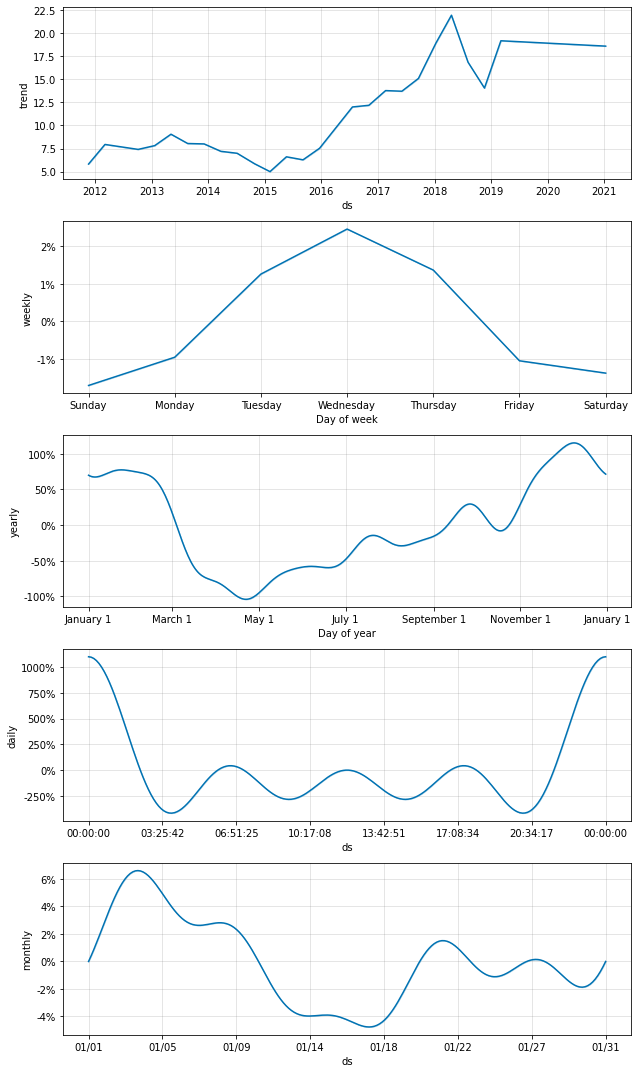

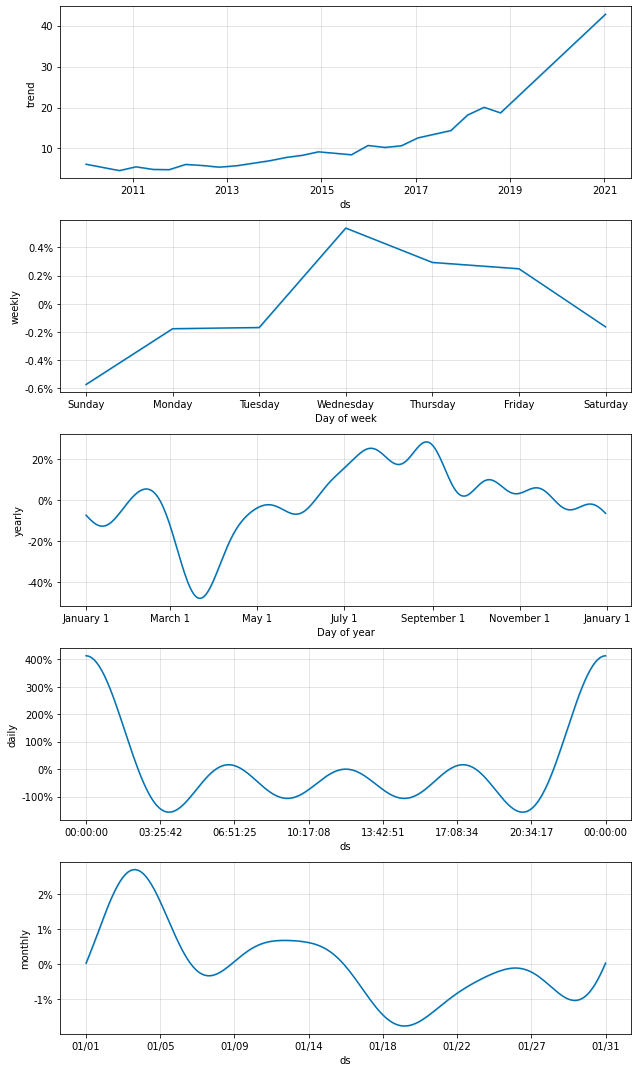

In [6]:
# данные, которые мы используем
_hist_from = "2010-01-01" # ну условно 10 лет, иногда больде данных дают более размытые результаты, тк сезонности тоже немного дрифтуют со временем
_hist_to   = "2020-12-31" # допустим до начала этого года, чтобы посмотреть как оно работает в ЭТОМ году

instruments = [ 
# вот тут через запятую в кавычках проставляются тикеры инструментов (не ограничено)
# тикеры надо искать на https://finance.yahoo.com/
 "USDT-RUB", "SBER.ME", "MSFT"
] 

!rm ./*.html
!rm ./*.csv

def read_yahoo(t, postfix = "=X"):
  #postfix = "=X" # that we need for Yahoo
  df = yf.download(t,start=_hist_from, end= _hist_to,  progress=False)
  df = df.drop( columns = ["Open","High","Low", "Adj Close", "Volume"] )
  # todo: fill in mnissing days
  all_days = pd.date_range(df.index.min(), df.index.max(), freq='D')
  df = df.reindex(all_days)
  #print(df)
  #print(df.columns)
  df['ds'] = df.index
  #df['y'] = df.Close
  #df = df.drop(columns=["Close"])
  # fill in missing value with the values of previous days (since Ap id daily and prices miss weekends)
  for i in range(0,len(df)):
    if str(df['Close'][i]) == "nan": df['Close'][i] = df['Close'][i-1]
  #print(df) #debug
  #sys.exit()

  # for cycle.tools
  ct = pd.DataFrame([])
  print(df.head())
  ct["time"] = df['ds']
  ct["value"] = df["Close"]
  print(ct.head()) 
  ct.to_csv(t+".csv", index = False)

  return (df)


def fb_seasons(df):
  #print(df.columns)
  #df['ds'] = df.index
  m = Prophet(daily_seasonality = True, yearly_seasonality = True, weekly_seasonality = True, seasonality_mode = 'multiplicative')
  m.add_seasonality(name='monthly', period=30.5, fourier_order=5)
  m.fit(df) # df is my timestamped data
  future = m.make_future_dataframe(periods=10, freq='D')
  forecast = m.predict(future)
  fig = m.plot_components(forecast) 
  forecast.columns # <--- All the columns of forecast dataframe, but I extract those which I need
  new_df = forecast[['ds', 'trend', 'weekly', 'yearly', 'daily', 'monthly']].copy() # <--- Copied those columns into new_df
  #  Weekly <======================================
  weekly_start = 0
  days = (pd.date_range(start='2017-01-02', periods=7) + 
          pd.Timedelta(days=weekly_start)) 
  df_w = seasonality_plot_df(m, days) 
  w_seas = m.predict_seasonal_components(df_w)
  w_data = [df_w['ds'], w_seas['weekly']]
  w_headers = ["ds", "weekly"]
  new_weekly = pd.concat(w_data, axis=1, keys=w_headers)
  new_weekly['ds'] = new_weekly['ds'].dt.day_name() 
  new_weekly = new_weekly.set_index('ds')
  #  Monthly <======================================
  monthly_start = 0
  days = (pd.date_range(start='2017-01-01', periods=31) + 
          pd.Timedelta(days=monthly_start)) 
  df_m = seasonality_plot_df(m, days) 
  m_seas = m.predict_seasonal_components(df_m)
  m_data = [df_m['ds'], m_seas['monthly']]
  m_headers = ["ds", "monthly"]
  new_monthly = pd.concat(m_data, axis=1, keys=m_headers)
  new_monthly['ds'] = new_monthly['ds'].dt.strftime('%m/%d')
  new_monthly = new_monthly.set_index('ds')
  #  Yearly <======================================
  yearly_start = 0
  days = (pd.date_range(start='2021-01-01', periods=365) + 
          pd.Timedelta(days=yearly_start)) 
  df_y = seasonality_plot_df(m, days) 
  y_seas = m.predict_seasonal_components(df_y) 
  y_data = [df_y['ds'], y_seas['yearly']]
  y_headers = ["ds", "yearly"]
  new_yearly = pd.concat(y_data, axis=1, keys=y_headers)
  new_yearly['ds'] = new_yearly['ds'].dt.strftime('%b/%d')
  new_yearly = new_yearly.set_index('ds')
  return ( new_weekly, new_monthly, new_yearly )

def get_seasonalities(dat): # returns dataframes of all instruments
  df_weekly  = pd.DataFrame([])
  df_monthly = pd.DataFrame([])
  df_yearly  = pd.DataFrame([])
  for d in dat:
    spread_name = d[0]
    df = d[1]
    df_w, df_m, df_y = fb_seasons(df) # get 'em
    df_w.columns = [spread_name]
    df_m.columns = [spread_name]
    df_y.columns = [spread_name]
    if len(df_weekly)==0:
      df_weekly =  df_w
    else:
      df_weekly[spread_name] = df_w
    if len(df_monthly)==0:
      df_monthly =  df_m
    else:
      df_monthly[spread_name] = df_m
    if len(df_yearly)==0:
      df_yearly =  df_y
    else:
      df_yearly[spread_name] = df_y
  return ( df_weekly, df_monthly, df_yearly) 


# download quotes from Yahoo
quotes = {}
dat = []
for c in instruments:
  df_cur = read_yahoo(c)
  quotes[c] = df_cur
  df = df_cur.reset_index()
  df['y'] =  df['Close']
  dat.append([c,df])

########################################
df_weekly, df_monthly, df_yearly  = get_seasonalities(dat)
df_weekly.to_csv("wi_yahoo.csv")
df_monthly.to_csv("mi_yahoo.csv")
df_yearly.to_csv("yi_yahoo.csv")

whtml =  df_weekly.plot_bokeh(kind="line", title="cycled weekly component", figsize=(800, 450), show_figure=False,return_html=True)
mhtml =  df_monthly.plot_bokeh(kind="line", title="cycled monthly component", figsize=(800, 450), xticks=[0, 9, 19, 29], show_figure=False,return_html=True)
yhtml =  df_yearly.plot_bokeh(kind="line", title="cycled yearly component", figsize=(800, 450), xticks=[0, 31, 59, 90, 120, 151, 181, 212, 243, 273, 304, 334], show_figure=False,return_html=True)
    
with open("i_yahoo_chart.html" , "a") as f:
  f.write("\n")
  f.write(whtml)
  f.write("\n")
  f.write(mhtml)
  f.write("\n")
  f.write(yhtml)
#############################

In [ ]:
#